# Capstone Project - Analysis of SDOT Accidents in Cold Conditions 
### Applied Data Science Capstone by IBM/Coursera

## Introduction <a name="introduction"></a>

In this project, we will be digging deeper into the accident data provided to us from the Seattle Department of Transportation (SDOT). The question we aim to answer is this: ***What specific roads in Seattle are most prone to accidents when affected by snow and ice?*** 

We are confident that our findings would be of good use to the SDOT and its associated government agencies (including, but not limited to the Seattle Police Department). For one thing, it would result in more efficient allocation of their resources to prevent injuries and damage to property caused by accidents in the area.

As an effect, the general populace of the city of Seattle would be safer, knowing those who watch over them have more information at their disposal.


## Data <a name="data"></a>

The data we have on hand is quite extensive, providing us with relevant attributes such as the location and time of the accident, as well as the consequent weather and lighting conditions when the event occurred. There are also details indicating how many pedestrians were involved, or if one or more cars that were affected were parked or not.

#### Breakdown

For this particular case, the Dependent Variable to predict will be the severity of the accident, or **SEVERITYCODE**. Note that the Severity Codes in the provided CSV file are only limited to two values: 1 and 2. According to the supplementary Metadata file, **SEVERITYCODE 1** corresponds to **Property Damage** and **2** corresponds to **Injury**. Thus, the model we will create will be geared towards ***predicting the likelihood of a potential accident to lead to Property Damage or Injury.***

**NOTE:** There were other Severity Codes disclosed on the Metadata: 0 (Unknown), 2b (Serious Injury), and 3 (Fatality). We believe these were omitted because the dataset already had thousands of rows to work on without these Severity Codes. 0 (Unknown) was most likely omitted because of its potential to confuse the model. Finally, we believe 2 (Injury) would be of utmost importance because we don't want to wait for serious injuries or fatalities to happen before we work on data. In other words if we could prevent injury we could definitely prevent worse things from happening. 


We have chosen to work with the following Attributes:

* **X, Y** - Coordinates of the general location of the collision. 
* **JUNCTIONTYPE** - Category of junction at which collision took place
* **WEATHER** - A description of the weather conditions during the time of the collision. 
* **ROADCOND** - The condition of the road during the collision.
* **LIGHTCOND** - The light conditions during the collision. 
* **SPEEDING** - Whether or not speeding was a factor in the collision.

These descriptions were gathered from the supplementary Metadata file. 

These are the columns we dropped, due to their lesser relevance, string properties, or because they are details of the accident after the fact:
**LOCATION, PERSONCOUNT, VEHCOUNT, INCDATE, INCDTTM, OBJECTID, INCKEY, COLDETKEY, REPORTNO, STATUS, ADDRTYPE, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, Duplicate SEVERITYCODE, COLLISIONTYPE, PEDCOUNT, PEDCYLCOUNT, SDOT_COLCODE, SDOT_COLDESC, INATTENTIONIND, UNDERINFL, PEDROWNOTGRNT, SDOTCOLNUM, ST_COLCODE, ST_COLDESC, SEGLANEKEY, CROSSWALKKEY, HITPARKEDCAR, SEVERITYDESC**


#### Data Selection/Cleaning

In [1]:
# Importing Libraries

import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
#Getting file from Coursera Link

!wget -O Data-Collisions.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

--2020-09-07 11:12:32--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘Data-Collisions.csv’

Data-Collisions.csv 100%[===================>]  70.49M  22.0MB/s    in 3.3s    

2020-09-07 11:12:35 (21.2 MB/s) - ‘Data-Collisions.csv’ saved [73917638/73917638]



In [3]:
#Read CSV
path = 'Data-Collisions.csv'
df_raw = pd.read_csv(path)
df_raw.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


After loading the CSV we load the precise columns that we need, as mentioned earlier. These will be in a dedicated dataframe for us to work with independent of the raw data straight from the CSV file. 

In [4]:
#Extracting Columns.

df = df_raw[['SEVERITYCODE', 'X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']]
print(df.shape)
print(df.dtypes)

(194673, 8)
SEVERITYCODE      int64
X               float64
Y               float64
JUNCTIONTYPE     object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
SPEEDING         object
dtype: object


In the dedicated datafame df, we converted NaN values in Column SPEEDING to 'N'. After that, we dropped all other Rows that had the values NaN, 'Unknown' and 'Other'

In [5]:
df.dropna(subset=['SEVERITYCODE', 'X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND'],inplace=True)
df['SPEEDING'].fillna('N', inplace=True)
df.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(180086, 8)

In [6]:
for y in df.columns:
    index_names = df[(df[y] == 'Unknown')].index 
    df.drop(index_names, inplace = True)

    index_names = df[(df[y] == 'Other')].index 
    df.drop(index_names, inplace = True)



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

The dedicated dataframe has been 'cleaned' of NaN and 'Unknown'/'Other' values. From here we have drawn all rows with ROADCOND of 'Snow/Slush' and 'Ice'. This takes us from a dataset of more than 100000 rows to a little less than 1900 rows.  

In [7]:
array=['Snow/Slush', 'Ice']
df_snow = df[df['ROADCOND'].isin(array)]

df_snow.shape

(1865, 8)

### Methodology

#### Visualization

We brought the numbers down that low to save on resources while still working on a relevant issue. Part of our analysis involved us using Folium. Using this tool we are able to see where vehicular accidents happen in Seattle, particularly those involving snow and ice. 

In [8]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Folium installed and imported!


After loading Folium, we proceeded with loading a generic map of Seattle. 

In [9]:
seattle_map = folium.Map(location=[47.608013, - 122.335167], zoom_start=12)

seattle_map

We went ahead and plotted each accident as detailed in df_snow. Imagine if we forced resources to plot all 150000 accidents!

In [10]:
accidents = folium.map.FeatureGroup()

for lat, lng, in zip(df_snow.Y, df_snow.X):
    accidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add incidents to map
seattle_map.add_child(accidents)

With this we could have gone through each point and make conclusions from here, but we opted to use Folium to group points for us.

In [11]:
from folium import plugins

seattle_map = folium.Map(location=[47.608013, - 122.335167], zoom_start=12)

acc_cat = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_snow.Y, df_snow.X, df_snow.SEVERITYCODE):
    folium.Marker(
        location=[lat, lng],
        icon=None,
    ).add_to(acc_cat)

# display map
seattle_map

(See my related LinkedIn article for more screencaptures of the same map, where I zoom in and point out more precise possible problematic areas)

### Additional Analysis

As a supplement to the above analysis we looked at some of the other columns on their own for more details on where SDOT can work on to avoid more accidents in case of cold weather.

In [12]:
df_snow['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              1198
At Intersection (intersection related)                340
Mid-Block (but intersection related)                  244
Driveway Junction                                      55
At Intersection (but not related to intersection)      25
Ramp Junction                                           3
Name: JUNCTIONTYPE, dtype: int64

In [13]:
df_snow['WEATHER'].value_counts()

Clear                       697
Snowing                     636
Overcast                    340
Raining                     103
Sleet/Hail/Freezing Rain     43
Fog/Smog/Smoke               35
Blowing Sand/Dirt             8
Severe Crosswind              3
Name: WEATHER, dtype: int64

In [14]:
df_snow['LIGHTCOND'].value_counts()

Dark - Street Lights On     850
Daylight                    846
Dawn                         81
Dusk                         35
Dark - No Street Lights      31
Dark - Street Lights Off     22
Name: LIGHTCOND, dtype: int64

This tells us that there can be as many snow/ice related accidents in daylight as there are at night (regardless of whether street lights are on/present or not). There can also be as many of these accidents in clear weather as there would be in snowing weather. 

However, accidents concerning Mid-Blocks that are not related to intersection stand out. 

### Modelling: K-Nearest Neighbors

We have also prepared a KNN model to predict the potential Severity of an accident given the Location, Junction Type, Weather/Road/Light Conditions, as well as if the vehicle in question was speeding.

Through testing we have determined the best K value to be 12 neighbors. This gives us an accuracy score of 0.7989276139410187

#### Model Preparation

Before setting up a model we've had to convert the dataframe into an array of workable float and integer values. Consequently we assigned all these independent variables to X, and the dependent variable SEVERITYCODE into y.  

In [17]:
X = df_snow[['X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']].values
X[0:5]

array([[-122.3107425, 47.63992717,
        'Mid-Block (not related to intersection)', 'Snowing',
        'Snow/Slush', 'Dark - Street Lights On', 'N'],
       [-122.3660043, 47.68583035,
        'Mid-Block (not related to intersection)',
        'Sleet/Hail/Freezing Rain', 'Ice', 'Dark - Street Lights On',
        'N'],
       [-122.3018681, 47.61893057,
        'Mid-Block (not related to intersection)', 'Clear', 'Ice',
        'Dusk', 'N'],
       [-122.28995309999999, 47.68304771,
        'Mid-Block (but intersection related)', 'Snowing', 'Snow/Slush',
        'Daylight', 'Y'],
       [-122.3473385, 47.66144499,
        'Mid-Block (not related to intersection)', 'Snowing',
        'Snow/Slush', 'Daylight', 'N']], dtype=object)

In [18]:
#Converting Categorical Values to Numerical Values

le_jtype = preprocessing.LabelEncoder()
le_jtype.fit(['Mid-Block (not related to intersection)', \
              'At Intersection (intersection related)','Mid-Block (but intersection related)',\
              'Driveway Junction','At Intersection (but not related to intersection)','Ramp Junction'])
X[:,2] = le_jtype.transform(X[:,2]) 

le_w = preprocessing.LabelEncoder()
le_w.fit(['Clear', 'Raining', 'Overcast', 'Snowing', 'Fog/Smog/Smoke', \
          'Sleet/Hail/Freezing Rain','Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy'])
X[:,3] = le_w.transform(X[:,3]) 

le_rcond = preprocessing.LabelEncoder()
le_rcond.fit(['Ice', 'Snow/Slush'])
X[:,4] = le_rcond.transform(X[:,4]) 

le_lcond = preprocessing.LabelEncoder()
le_lcond.fit(['Daylight', 'Dark - Street Lights On', 'Dusk', 'Dawn', \
              'Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Unknown Lighting'])
X[:,5] = le_lcond.transform(X[:,5]) 

le_speed = preprocessing.LabelEncoder()
le_speed.fit(['Y','N'])
X[:,6] = le_speed.transform(X[:,6]) 


X[0:5]

array([[-122.3107425, 47.63992717, 4, 8, 1, 2, 0],
       [-122.3660043, 47.68583035, 4, 7, 0, 2, 0],
       [-122.3018681, 47.61893057, 4, 1, 0, 6, 0],
       [-122.28995309999999, 47.68304771, 3, 8, 1, 5, 1],
       [-122.3473385, 47.66144499, 4, 8, 1, 5, 0]], dtype=object)

In [19]:
y = df_snow["SEVERITYCODE"]

y[0:5]

682    1
799    1
854    1
893    1
954    1
Name: SEVERITYCODE, dtype: int64

#### Train/Test Split

True to the methods we have been taught thoughout these courses, we have established a Train/Test Split for the model to 'play' with. 

In [20]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.53847055,  0.40359432,  0.64757076,  1.26129799,  1.13381622,
        -0.9438841 , -0.61267343],
       [-1.13973196,  1.13941605,  0.64757076,  0.93508515, -0.88197715,
        -0.9438841 , -0.61267343],
       [ 0.80797029,  0.06702168,  0.64757076, -1.02219185, -0.88197715,
         1.61104167, -0.61267343],
       [ 1.16980763,  1.09481071, -0.17344859,  1.26129799,  1.13381622,
         0.97231022,  1.63219091],
       [-0.57288483,  0.74852205,  0.64757076,  1.26129799,  1.13381622,
         0.97231022, -0.61267343]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1492, 7) (1492,)
Test set: (373, 7) (373,)


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

We used iteration (as was used in previous courses) in determinining the best value for K; but, instead of iterating up until 10 neighbors we thought to push the loop to 100 to see if there was anything we were missing. 

In [29]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.70241287, 0.78016086, 0.73458445, 0.77479893, 0.72922252,
       0.78016086, 0.7613941 , 0.78552279, 0.78284182, 0.78820375,
       0.78552279, 0.79892761, 0.79356568, 0.79356568, 0.79892761,
       0.79356568, 0.79892761, 0.79624665, 0.79892761, 0.79892761,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79356568,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79356568, 0.79624665,
       0.79624665, 0.79624665, 0.79356568, 0.79624665, 0.79356568,
       0.79624665, 0.79624665, 0.79624665, 0.79088472, 0.79356568,
       0.79088472, 0.79356568, 0.79356568, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624665,
       0.79624665, 0.79624665, 0.79624665, 0.79624665, 0.79624

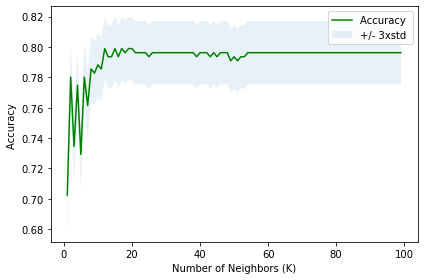

In [30]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [31]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7989276139410187 with k= 12


It turns out that the best K value was a little past 10: 12 neighbors would leave us with the most accurate model. 